In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

In [2]:

df = pd.read_csv('D:/Documents/Bicocca/2Year/TimeSeries/project/data/ts2024.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], format='ISO8601')

hourly_index = pd.date_range(start=df['DateTime'].min(), end=df['DateTime'].max(), freq='H')

hourly_index = pd.date_range(start=df['DateTime'].min(), end=df['DateTime'].max(), freq='H')
df = df.set_index(hourly_index).rename_axis('date')

df['DayOfWeek'] = df.index.dayofweek


train = df[df['X'].notna()]  
test = df[df['X'].isna()]  



train2 = train[:-1000]
test = train[-1000:]

In [3]:
# Формируем DataFrame
df = pd.DataFrame({'Date': train2.index, 'Value': train2.X})



lag = 5  
for i in range(1, lag + 1):
    df[f'lag_{i}'] = df['Value'].shift(i)


df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
from catboost.utils import get_gpu_device_count
print("Available GPU count:", get_gpu_device_count())


Available GPU count: 1


In [5]:

feature_cols = [f'lag_{i}' for i in range(1, lag + 1)]
X = df[feature_cols].values    
y = df['Value'].values        

In [6]:
import catboost
print(catboost.__version__)


1.2.7


In [7]:
model = CatBoostRegressor(iterations=500,
                          learning_rate=0.05,
                          depth=10,
                          task_type="GPU",
                          devices='0',
                          verbose=1)
model.fit(X, y)



0:	learn: 0.0469361	total: 53.1ms	remaining: 26.5s
1:	learn: 0.0450911	total: 94.2ms	remaining: 23.5s
2:	learn: 0.0433416	total: 134ms	remaining: 22.2s
3:	learn: 0.0417090	total: 174ms	remaining: 21.6s
4:	learn: 0.0401732	total: 215ms	remaining: 21.2s
5:	learn: 0.0387071	total: 256ms	remaining: 21.1s
6:	learn: 0.0373411	total: 296ms	remaining: 20.8s
7:	learn: 0.0360701	total: 336ms	remaining: 20.6s
8:	learn: 0.0348674	total: 375ms	remaining: 20.5s
9:	learn: 0.0337437	total: 417ms	remaining: 20.4s
10:	learn: 0.0326727	total: 458ms	remaining: 20.3s
11:	learn: 0.0316902	total: 498ms	remaining: 20.3s
12:	learn: 0.0307639	total: 538ms	remaining: 20.2s
13:	learn: 0.0298796	total: 578ms	remaining: 20.1s
14:	learn: 0.0290780	total: 618ms	remaining: 20s
15:	learn: 0.0283092	total: 659ms	remaining: 19.9s
16:	learn: 0.0276135	total: 700ms	remaining: 19.9s
17:	learn: 0.0269590	total: 740ms	remaining: 19.8s
18:	learn: 0.0263478	total: 781ms	remaining: 19.8s
19:	learn: 0.0257750	total: 821ms	remaini

In [8]:
n_forecast = len(test)  
predictions = [] 


last_value = df.iloc[-1]['Value']


last_features = X[-1]

forecast_input = np.concatenate(([last_value], last_features[:-1]))
current_input = forecast_input.copy()
for i in range(n_forecast):
    # Приводим current_input к форме (1, lag)
    pred = model.predict(current_input.reshape(1, -1))
    predictions.append(pred[0])

    current_input = np.concatenate(([pred[0]], current_input[:-1]))


last_date = df.iloc[-1]['Date']
future_dates = test.index

forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': predictions})

print(forecast_df.head(10))

                 Date  Forecast
0 2016-10-20 08:00:00  0.095158
1 2016-10-20 09:00:00  0.068850
2 2016-10-20 10:00:00  0.054611
3 2016-10-20 11:00:00  0.053985
4 2016-10-20 12:00:00  0.055585
5 2016-10-20 13:00:00  0.050839
6 2016-10-20 14:00:00  0.046245
7 2016-10-20 15:00:00  0.042810
8 2016-10-20 16:00:00  0.039319
9 2016-10-20 17:00:00  0.036051


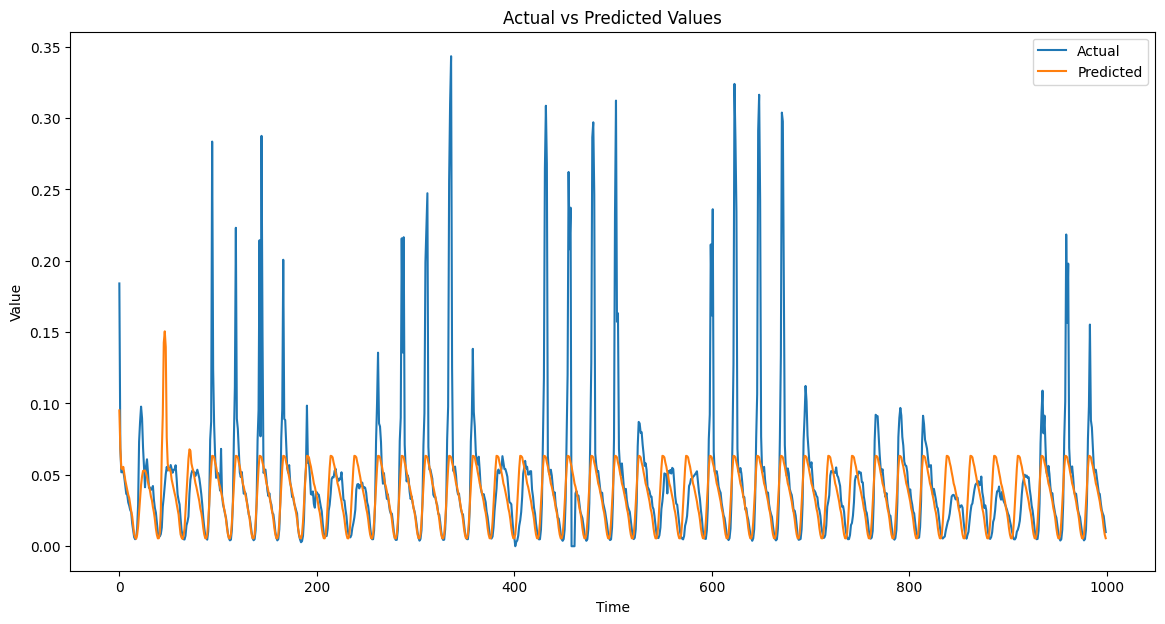

KeyError: 'predicted'

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['X'].tolist(), label='Actual')
plt.plot(forecast_df['Forecast'].tolist(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


# Calculating MAPE
mape = mean_absolute_percentage_error(test['X'], test['predicted'])
print(f'MAPE: {mape:.2f}')

In [11]:
#Catboost

In [16]:
def create_lags(df, lag=5):
    df = df.copy()
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['X'].shift(i)
    return df

lag = 1000
data = create_lags(train, lag=lag)  # Создаем лаги на 5 шагов назад
data.dropna(inplace=True)

In [20]:
last_train = train2.iloc[-lag:]

In [22]:
last_train = train2.iloc[-lag:]
combined = pd.concat([last_train, test], ignore_index=True)
combined_with_lags = create_lags(combined, lag=lag)
# Отбрасываем первые lag строк, которые сформированы только на основе тренировочных данных
test_with_lags = combined_with_lags.iloc[lag:]

In [7]:
X = data[[x for x in data.columns if x.startswith('lag_')]]
y = data['X']

In [ ]:
last_train = train_data.iloc[-lag:]
combined = pd.concat([last_train, test_data], ignore_index=True)
combined_with_lags = create_lags(combined, lag=lag)
# Отбрасываем первые lag строк, которые сформированы только на основе тренировочных данных
test_with_lags = combined_with_lags.iloc[lag:]

In [17]:
# 4. Обучение модели
model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=200)
model.fit(X, y)

0:	learn: 0.0472719	total: 7.3ms	remaining: 7.3s
200:	learn: 0.0149109	total: 1.25s	remaining: 4.99s
400:	learn: 0.0118746	total: 2.45s	remaining: 3.67s
600:	learn: 0.0098422	total: 3.65s	remaining: 2.42s
800:	learn: 0.0084304	total: 4.86s	remaining: 1.21s
999:	learn: 0.0073065	total: 6.13s	remaining: 0us


In [18]:
n_predictions = len(test)  
last_known_values = X.iloc[-1].values.reshape(1, -1)  


# Массив для хранения предсказанных значений
predictions = []

for _ in range(n_predictions):
    # Получаем предсказание для следующего шага
    next_pred = model.predict(last_known_values)
    predictions.append(next_pred[0])

    # Обновляем данные для следующего шага (создаем новые лаги)
    new_lag = np.roll(last_known_values[0], 1)  # Сдвигаем лаги
    new_lag[0] = next_pred  # Подставляем предсказанное значение как новый лаг

    # Обновляем последний набор признаков для следующего предсказания
    last_known_values = new_lag.reshape(1, -1)

In [19]:
test['predicted'] = predictions


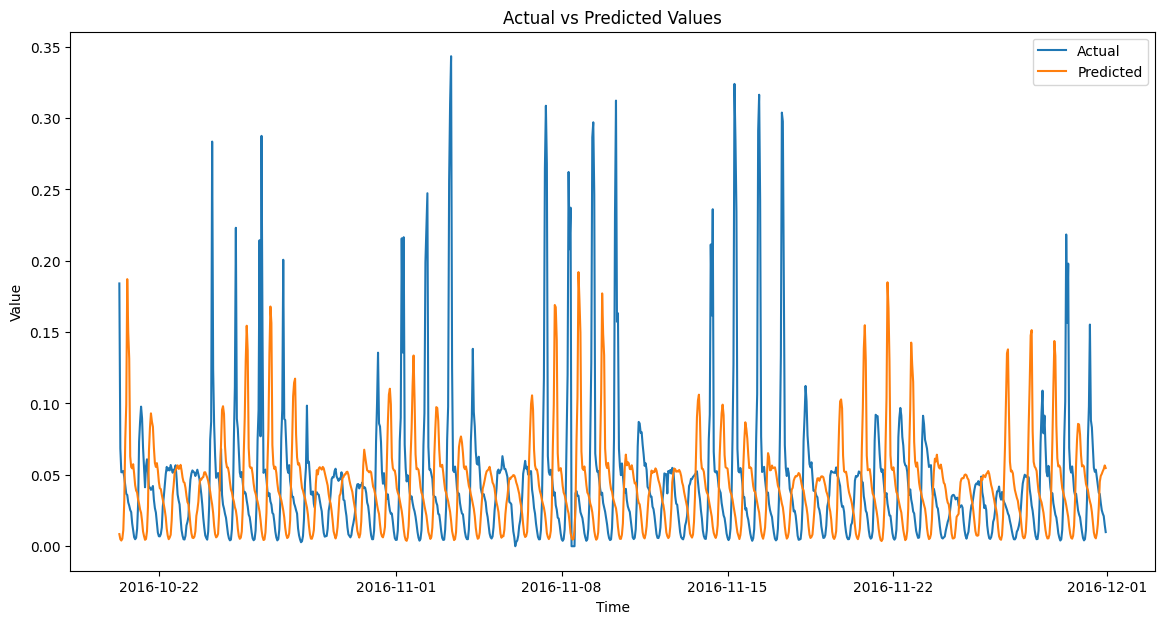

MAPE: 337368654808.33


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['X'], label='Actual')
plt.plot(test['predicted'], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Calculating MAPE
mape = mean_absolute_percentage_error(test['X'], test['predicted'])
print(f'MAPE: {mape:.2f}')


In [21]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [24]:


# Define a function to create input features and target variables for multi-step forecasting
def create_dataset(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i : i + n_steps_in])
        y.append(data[i + n_steps_in : i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

In [25]:
n_steps_in, n_steps_out = 2000, len(test)
X, y = create_dataset(train['X'].values, n_steps_in, n_steps_out)

In [27]:
base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model = MultiOutputRegressor(base_model)

In [28]:
model.fit(X, y)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000002A7EB6B6E30>>
Traceback (most recent call last):
  File "d:\Anaconda\envs\yandex-market\lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


: 

In [2]:
import timesfm


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


d:\Anaconda\envs\time-series\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM.


ModuleNotFoundError: No module named 'torch'

In [ ]:
import timesfm

tfm = timesfm.TimesFm(
    context_len=<context>,
    horizon_len=<horizon>,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=<backend>,
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")
